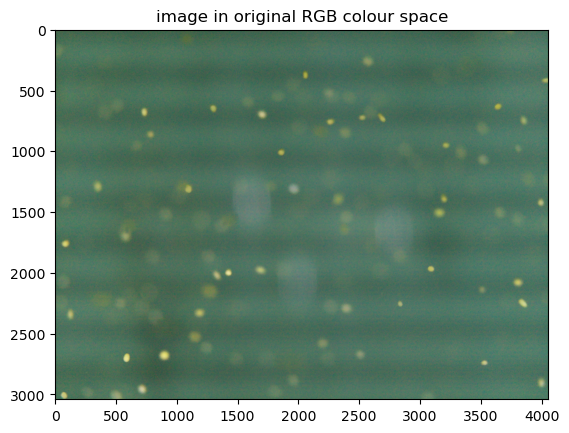

In [ ]:
# a quick script to test if I can easily repair rolling shutter light banding in post

import cv2 as cv
import os
import matplotlib.pyplot as plt


# location of the file
img_name = '/home/dtsai/Data/cslics_datasets/flickering/2024-11-26_15-00-24_clean.jpg'

# read in the image
img = cv.imread(img_name) # as BGR
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('image in original RGB colour space')
plt.show()




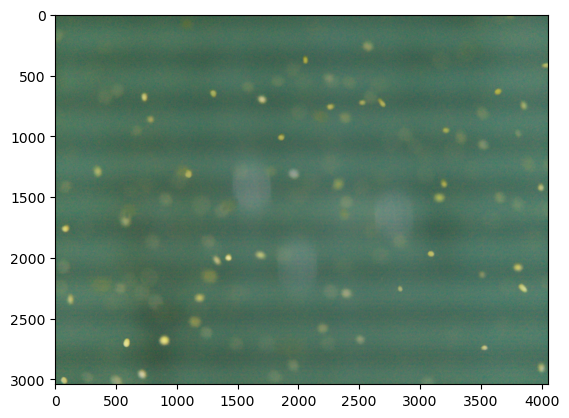

In [ ]:
# compare this to just blurring the image

kernel_size = 11
std_dev = 1
img_blur = cv.GaussianBlur(img, (kernel_size, kernel_size), std_dev)

plt.figure()
plt.imshow(img_blur)
plt.show()

# clearly doesn't actually get rid of the bands


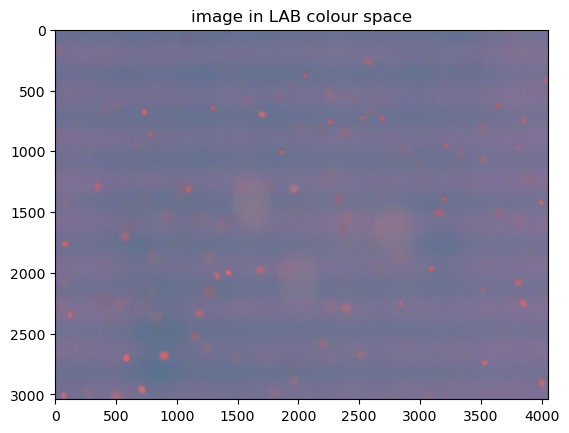

In [ ]:
# convert the image to appropriate colour space
img_lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)

# LAB colour space: 
# Lightness value - cube root of the relative luminance with offset near black
plt.imshow(img_lab)
plt.title('image in LAB colour space')
plt.show()



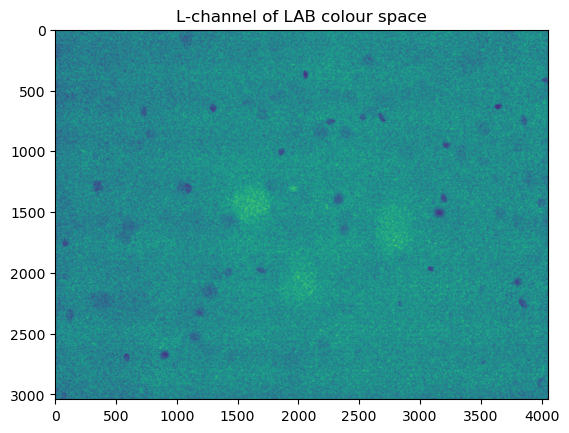

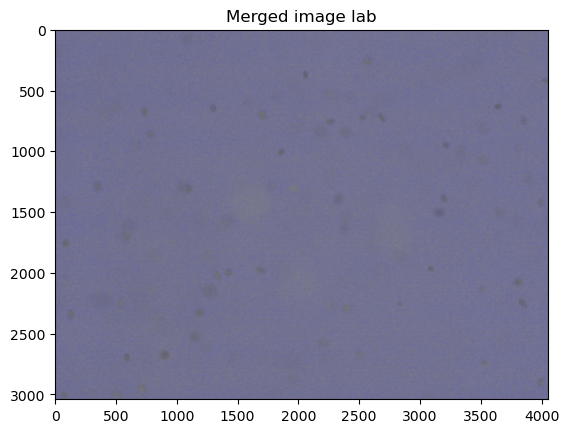

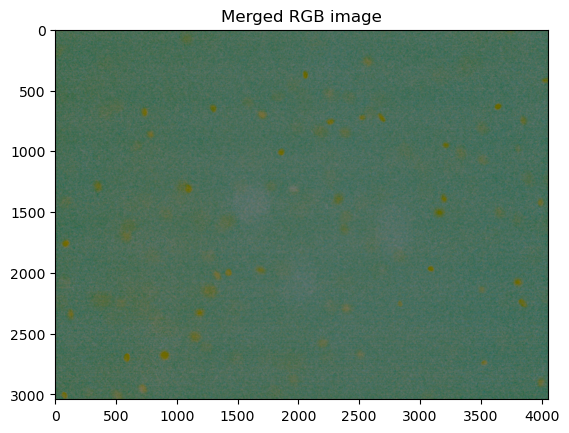

In [19]:
# apply filter to L-channel

L_channel = 1
plt.figure()
plt.imshow(img_lab[:,:,L_channel])
plt.title('L-channel of LAB colour space')

kernel_size = 21
std_dev = 1
l_blur = cv.GaussianBlur(img_lab[:,:,L_channel], (kernel_size, kernel_size), std_dev)

img_lab_merge = cv.merge([l_blur, img_lab[:,:,1], img_lab[:,:,2]])
plt.figure()
plt.imshow(img_lab_merge)
plt.title('Merged image lab')

img_rgb_merge = cv.cvtColor(img_lab_merge, cv.COLOR_LAB2BGR)

plt.figure()
plt.imshow(img_rgb_merge)
plt.title('Merged RGB image')
plt.show()



# convert back to BGR
# display image

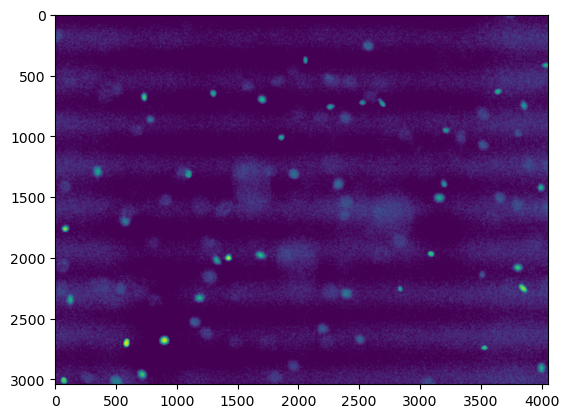

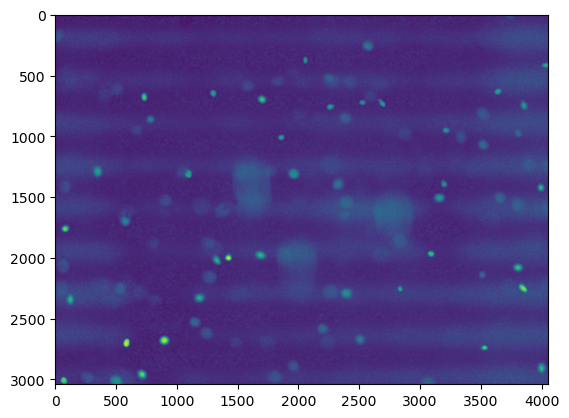

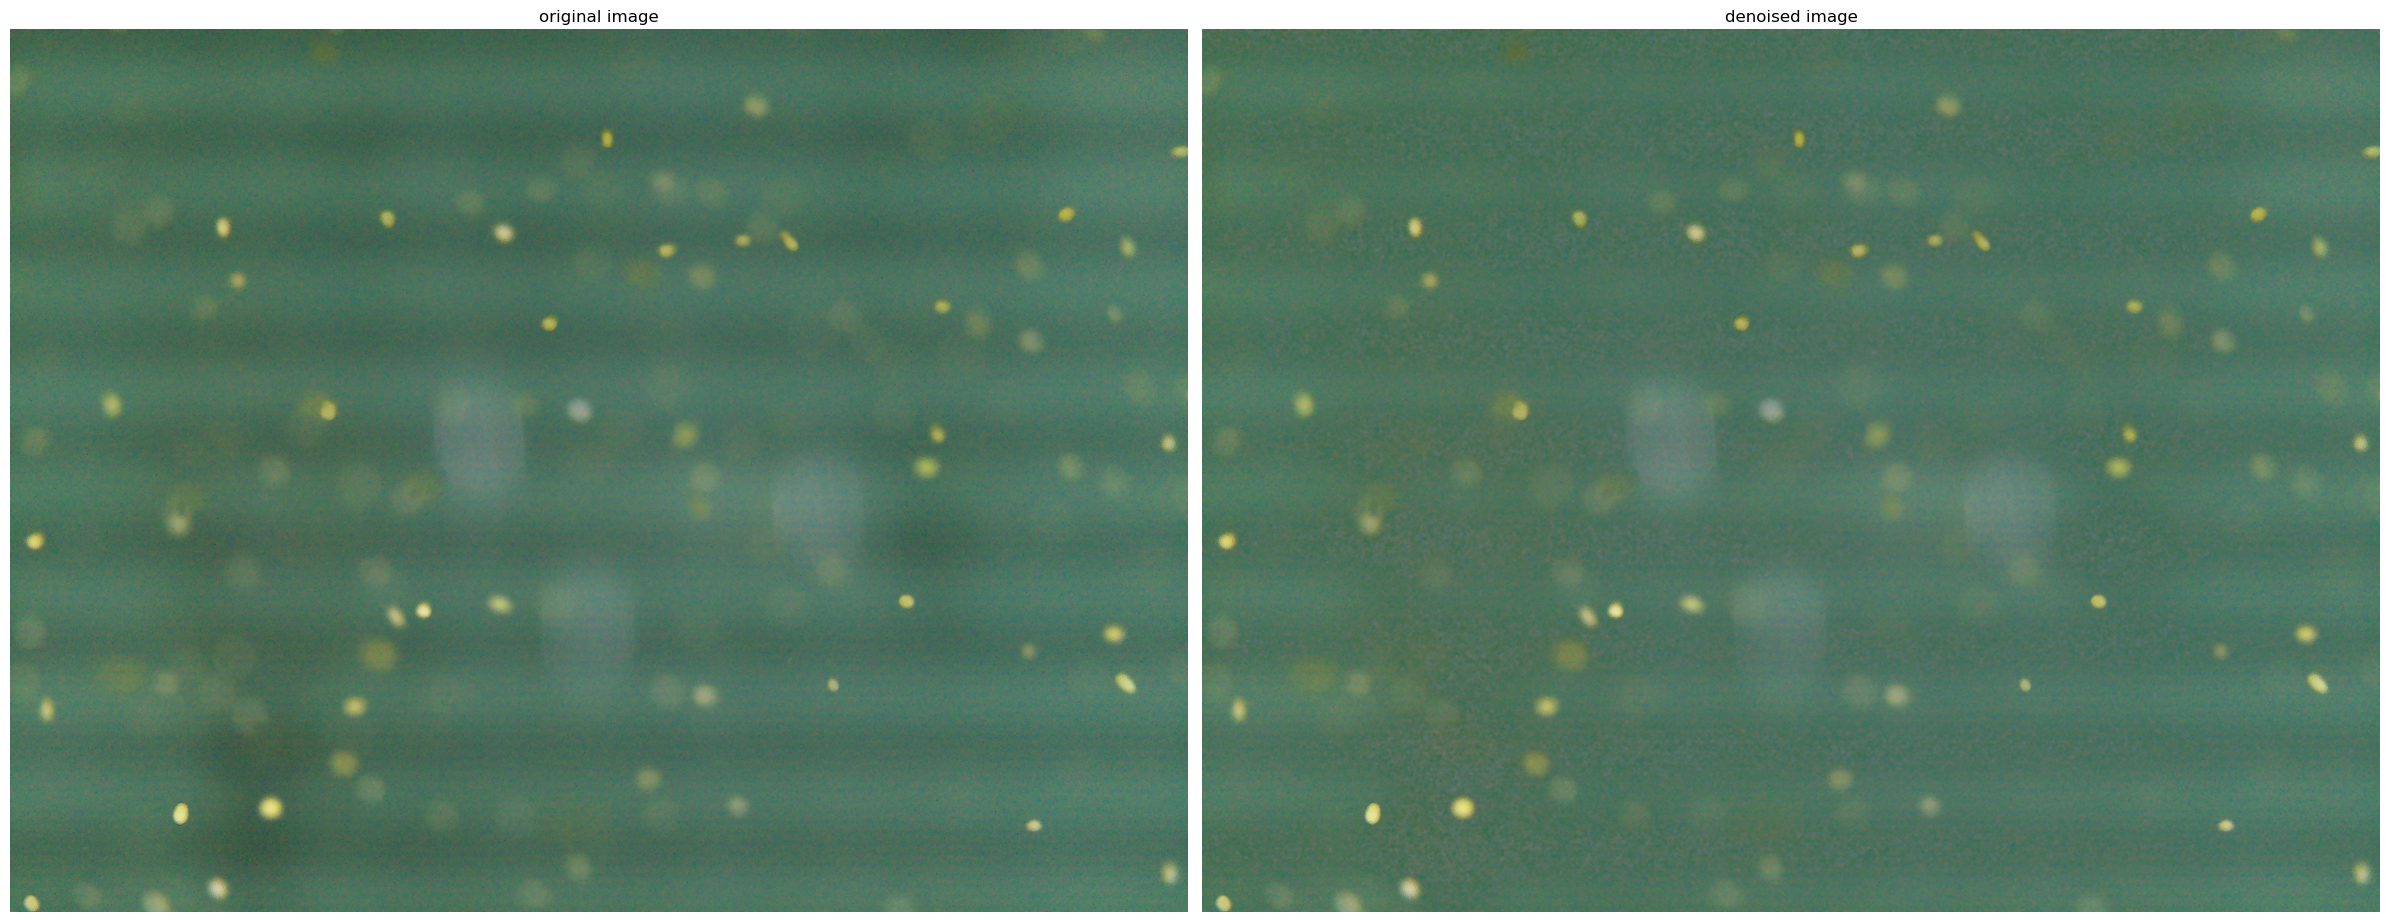

In [ ]:
# attempt to retain the high frequency components from LAB space

L_high_freq = cv.subtract(img_lab[:,:,0], l_blur) # extract the high frequency details

plt.figure()
plt.imshow(L_high_freq)

# apply stronger blurring to remove banding
L_smooth = cv.GaussianBlur(l_blur, (21,21),1)

# restore high frequency details
L_restore = cv.add(L_smooth, L_high_freq)

plt.figure()
plt.imshow(L_restore)

# convert back
img_lab_denoise = cv.merge([L_restore, img_lab[:,:,1], img_lab[:,:,2]])
img_rgb_denoise = cv.cvtColor(img_lab_denoise, cv.COLOR_LAB2BGR)

fig, axes = plt.subplots(1, 2, figsize=(24,12))
axes[0].imshow(img)
axes[0].set_title('original image')
axes[0].axis('off')

axes[1].imshow(img_rgb_denoise)
axes[1].set_title('denoised image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

This gets rid/redeuces (with the right thresholds) the background perceptual brightness, which might not be good for the bright corals, which we need to count.

Really, we're interested in the high-frequency components of the image, but want to remove the low frequency components in the background along one axis, so try a high-pass filter to detect and remove banding.

Fast Fourier Transforms (FFTs)?


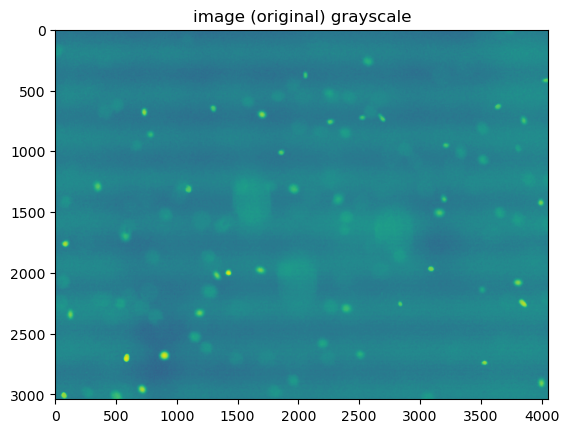

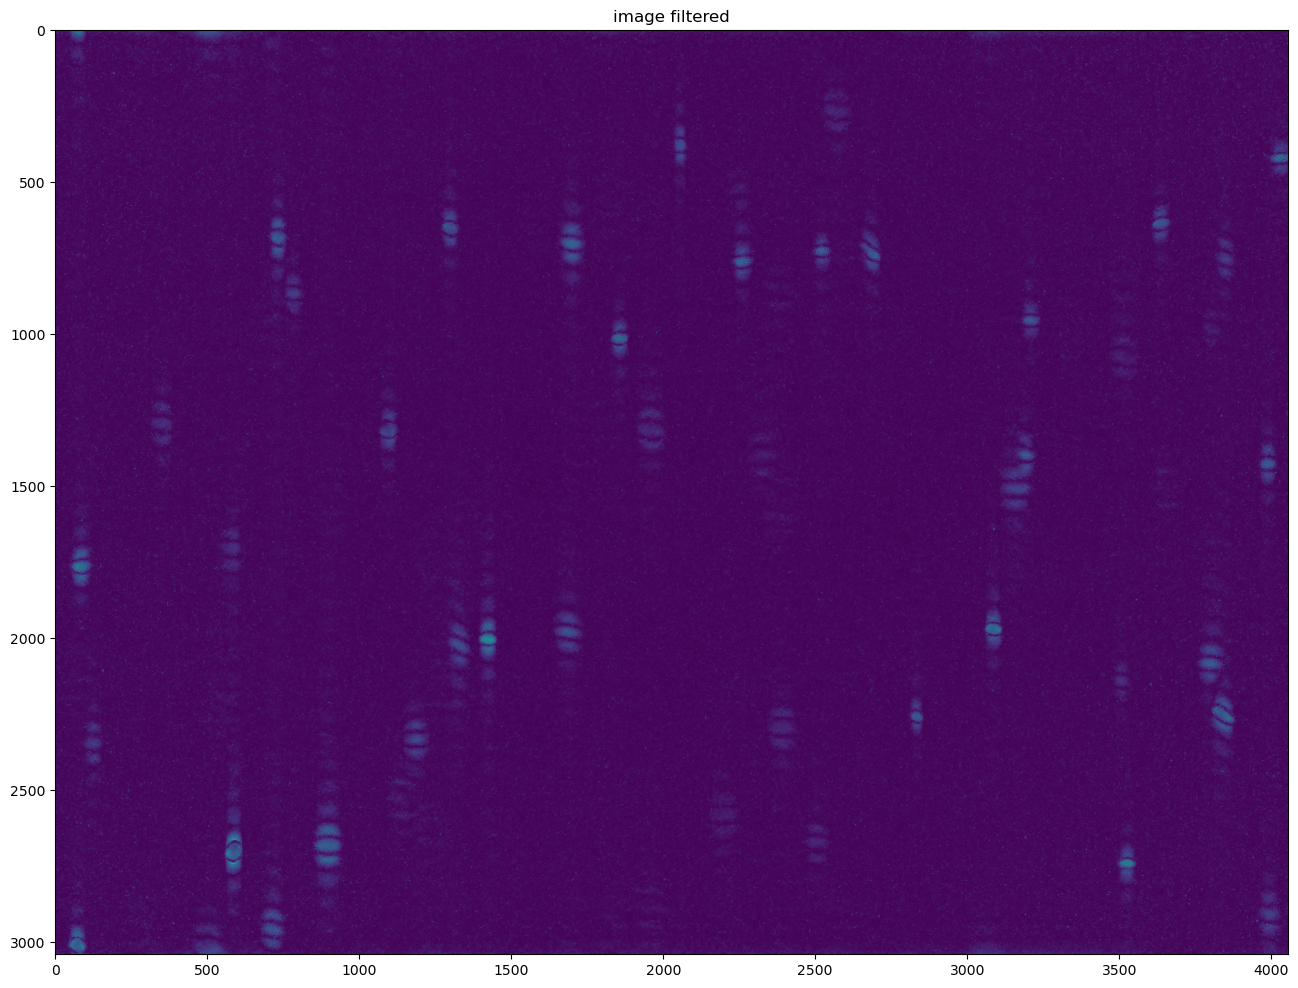

In [30]:
# convert to grayscale (starting from original image)
# apply Fourier Transform to analyze frequency content
# suppress horizontal bands in freq space
# apply inverse Fourier Transform to reconstruct the image

import numpy as np

img_g = cv.cvtColor(img, cv.COLOR_RGB2GRAY)

# show grayscale image
plt.figure()
plt.imshow(img_g)
plt.title('image (original) grayscale')


# fft
dft = np.fft.fft2(img_g)
dft_shift = np.fft.fftshift(dft)

# create mask to remove low frequency horizontal bands
band_pix = 20
rows, cols = img_g.shape
crow, ccol = rows // 2, cols // 2
mask = np.ones((rows, cols), np.uint8)
mask[crow-band_pix:crow+band_pix,:]=0

# apply the mask
dft_shift_filtered = dft_shift * mask

# inverse fft
dft_inverse = np.fft.ifftshift(dft_shift_filtered)
img_filt = np.fft.ifft2(dft_inverse)
img_filt = np.abs(img_filt)

# normalise & save
img_filt = cv.normalize(img_filt, None, 0, 255, cv.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(24,12))
plt.imshow(img_filt)
plt.title('image filtered')
plt.show()
